## Making Compelling Graphical Displays of Information

This lab covers the basics of creating graphics in `ggplot()`, a package bundled with `tidyverse`. Here, we walk through a number of different graph types. My goal is to expose you to a range of graphs and graph adjustments that you can use as a template in your projects. 

The dataset we will use for the lab comes from the New York City Department of Health and Mental Hygenie (DOHMH) and made available on [NYC Open Data portal](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data). I have posted a cleaned and subsetted version of these data on my GitHub course repository. We'll ingest this data directly from GitHub.

In [1]:
# install only if needed:
# install.packages("pacman")

pacman::p_load(tidyverse, modelsummary)

 
         This mode cannot be fully supported. It will create various problems
         with time zone changes and daylight saving time adjustments. The RTC
         time is never updated, it relies on external facilities to maintain it.
         If at all possible, use RTC in UTC by calling
         'timedatectl set-local-rtc 0'.


Now let's load our dataset. You can pull it directly from my GitHub repository using the url and the `read_csv()` function from **tidyverse**. These data are from 2022 - the beginning of 2025. The main outcome variable of interest to us is `SCORE`: which is a numeric rating from the Department of Health summarizing the amount and severity of violations found during the initial restaurant inspection. *Higher scores are worse.* Any score greater than 13 results in a non-A rating and triggers follow-up actions ranging from increased frequency of inspections to restaurant closure. 

In [2]:
nyc.inspect <- read_csv("https://raw.githubusercontent.com/bowendc/511_labs/refs/heads/main/DOHMH_NYC_inital_restaurant_inspections.csv")  

# take a look at your data frame using view() or by clicking on
# the table icon in the Environment window next to the data frame.

head(nyc.inspect)

Rows: 135850 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (17): DBA, BORO, BUILDING, STREET, CUISINE DESCRIPTION, INSPECTION DATE...
dbl  (12): CAMIS, ZIPCODE, PHONE, SCORE, Latitude, Longitude, Community Boar...
lgl   (1): Location Point1
date  (1): inspect.date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 


# A tibble: 6 × 31
     CAMIS DBA        BORO  BUILDING STREET ZIPCODE  PHONE `CUISINE DESCRIPTION`
     <dbl> <chr>      <chr> <chr>    <chr>    <dbl>  <dbl> <chr>                
1 50033289 CARLO'S B… Manh… 625      8 AVE…   10018 2.01e9 Bakery Products/Dess…
2 50043521 SUBWAY     Manh… 442      WEST …   10036 2.13e9 Sandwiches           
3 41166868 SANGRIA T… Quee… 95-41    SUTPH…   11435 7.18e9 Spanish              
4 50139652 DOMINICAN… Stat… 2180     FORES…   10303 7.18e9 Spanish              
5 41524607 THE WHISK… Broo… 44       BERRY…   11249 7.18e9 American             
6 50119085 POETICA C… Broo… 240      7 AVE…   11215 9.18e9 Coffee/Tea           
# ℹ 23 more variables: `INSPECTION DATE` <chr>, ACTION <chr>,
#   `VIOLATION CODE` <chr>, `VIOLATION DESCRIPTION` <chr>,
#   `CRITICAL FLAG` <chr>, SCORE <dbl>, GRADE <chr>, `GRADE DATE` <chr>,
#   `RECORD DATE` <chr>, `INSPECTION TYPE` <chr>, Latitude <dbl>,
#   Longitude <dbl>, `Community Board` <dbl>, `Council District` <chr>,
#

## Making Graphs with ggplot2

**ggplot2** is an outstanding, professional, graphic syntax for R, bundled as part of the **tidyverse**. Let's explore some of the basic plot types and `ggplot()` syntax. 

### Histograms and density plots

Histograms are graphs that present the distribution of a variable measured at the continuous or interval level by grouping the values into "bins". 

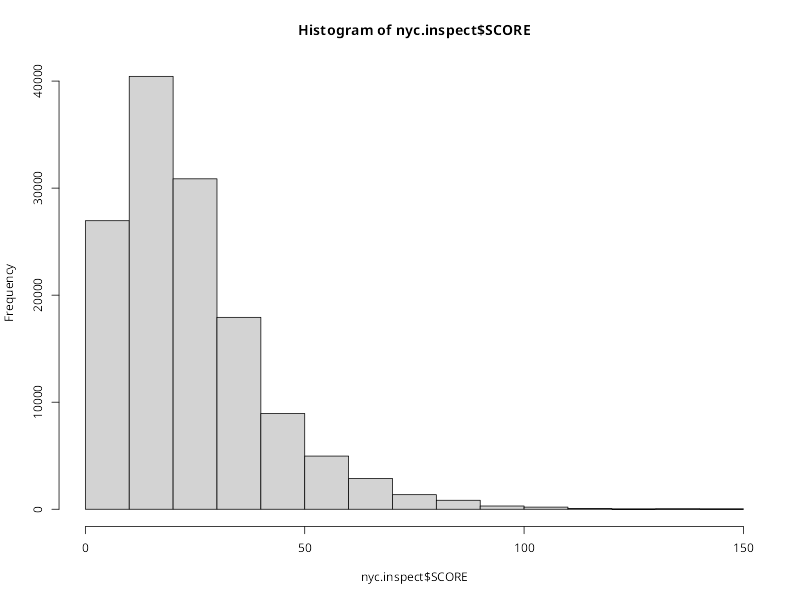

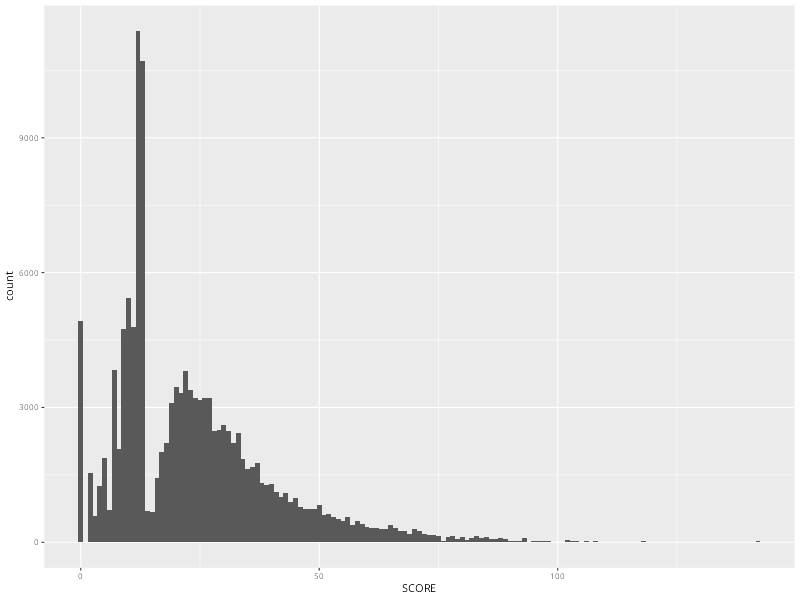

In [3]:
# in base R
hist(nyc.inspect$SCORE)

# in ggplot
# the aes() stands for "aesthetics"

ggplot(data = nyc.inspect, mapping = aes(x = SCORE)) +
    geom_histogram(binwidth = 1)                       # try changing the binwidht

Now, let's make it look better by changing the y-axis to a percentage and changing the color of the histogram. 

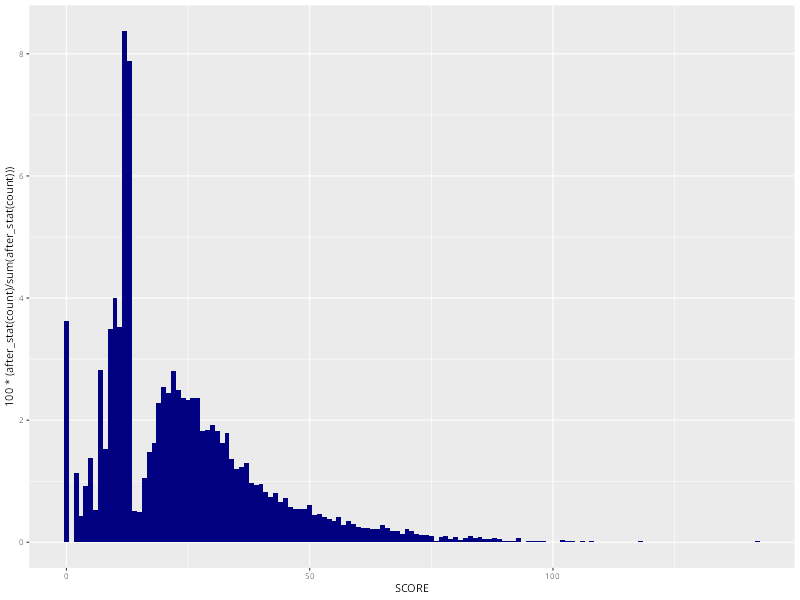

In [4]:
ggplot(nyc.inspect, mapping = aes(x = SCORE)) +
  geom_histogram(aes(y =100*( after_stat(count) / sum(after_stat(count)))), binwidth = 1,
                  fill = "navy")

Again, this looks better! Now the y-axis makes sense. However, the y-axis title still is confusing. Let's continue editing by adding titles.

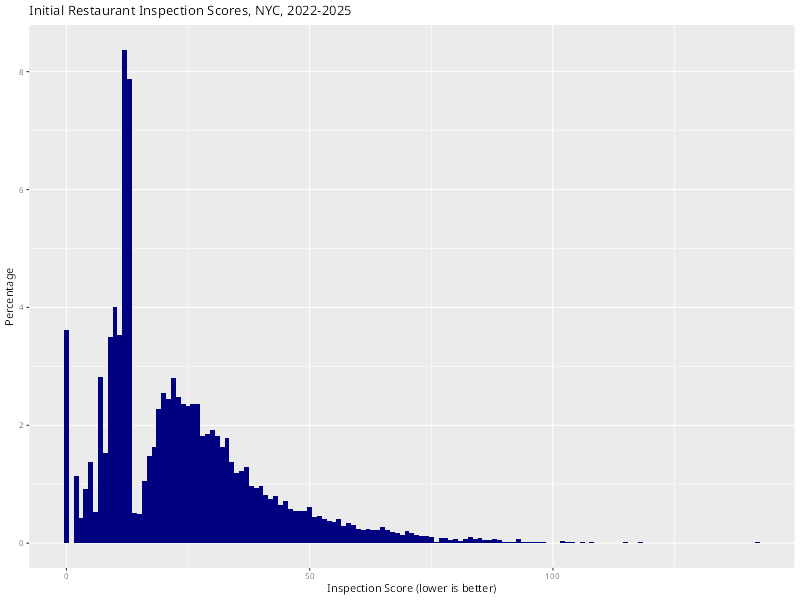

In [5]:
# here we take our previous function and add a + at the end of the line,
# then including our labs() call. 

# we can store the graph as an object and add to it later 
plot1 <- ggplot(nyc.inspect, mapping = aes(x = SCORE)) +
  geom_histogram(aes(y =100*( after_stat(count) / sum(after_stat(count)))), binwidth = 1,
                  fill = "navy") +
    labs(title = "Initial Restaurant Inspection Scores, NYC, 2022-2025",
       x = "Inspection Score (lower is better)",
       y = "Percentage")

# type the name to view the plot
plot1

Finally, let's play with the theme of the plot. `ggplot` themes toggle a range of settings. [Try out a few of these](https://ggplot2.tidyverse.org/reference/ggtheme.html) to see how they look! 

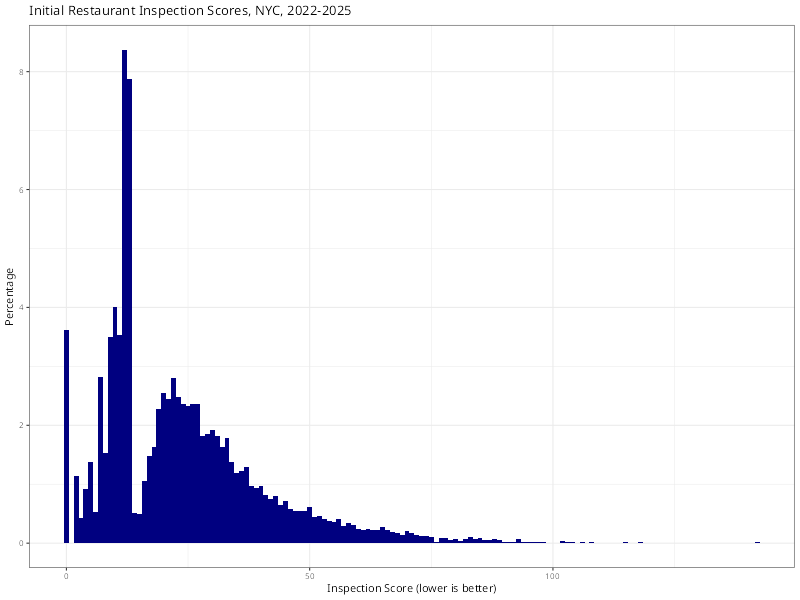

In [6]:
# because we stored the graph, all we need to do to add layers in refer to
# the named object

plot1 + theme_bw()

We can present the same graph as smoothed distributions using `geom_density` instead of `geom_histogram`:

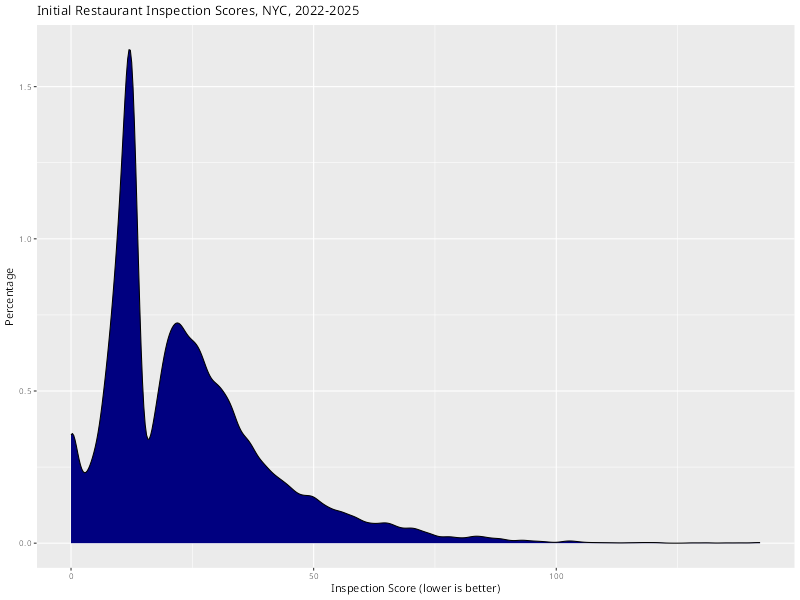

In [7]:

# the code is the same here; I just removed the binwidth() argument.

ggplot(nyc.inspect, mapping = aes(x = SCORE)) +
  geom_density(aes(y =100*( after_stat(count) / sum(after_stat(count)))),
                  fill = "navy") +
    labs(title = "Initial Restaurant Inspection Scores, NYC, 2022-2025",
       x = "Inspection Score (lower is better)",
       y = "Percentage")

What if we wanted to compare the distributions of two variables? Let's add another `geom_histogram` plot to this graph. To improve visability, let's change the opacity of the colors using the argument `alpha`. I'm also going to move the `data` argument into the `geom_histogram` calls so we can filter data. Let's see if SUBWAY restuarant scores differ from the rest of the NYC restuarant scores. To do so, we'll use a couple selection functions useful for when you have text data (known as strings).

In [8]:
# here, we make a new variable named 'subway' which takes a 1 if the name 
# is equal to "SUBWAY" and a 0 otherwise. That's what the if_else() function 
# does.

# the toupper() function will convert all text to upper-case, just in case
# some text in the textfield was lower case.

# remember the we need 2 equal signs when testing for equality.
nyc.inspect$subway <- if_else(toupper(nyc.inspect$DBA) == "SUBWAY", 1, 0) 

# did it work?
table(nyc.inspect$subway)

# of course, we also could have used mutate() to do this too!


     0      1 
134637   1213 

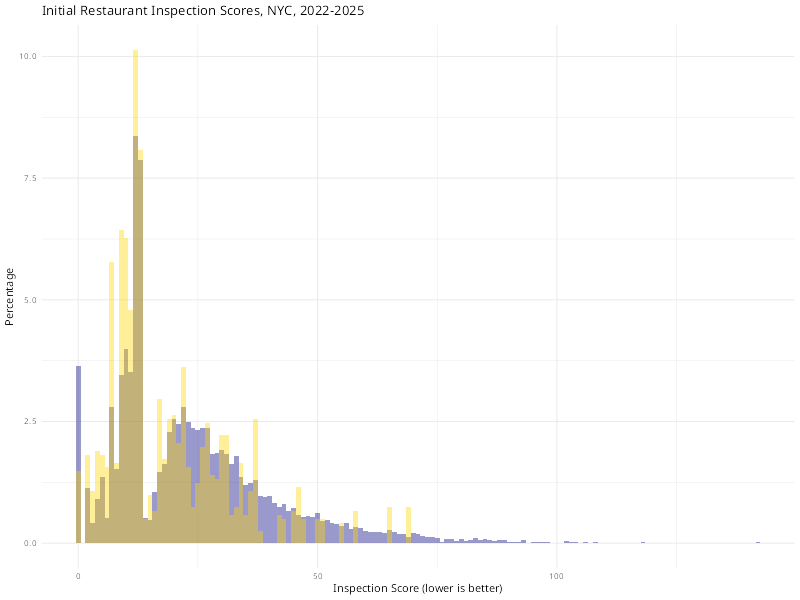

In [9]:
# here, we move the data and aes args INSIDE geom_histogram().
# that way we can use filter() to subset the data inside the 
# geom_histogram call. 

# alpha toggles opacity / transparency. 0 is fully transparent.
# 1 is fully opaque.

plot2 <- ggplot() +
  geom_histogram(nyc.inspect |> filter(subway == 0), 
                mapping = aes(x = SCORE,
                              y =100*( after_stat(count) / sum(after_stat(count)))),
                binwidth = 1, fill = "navy", alpha = .4) +
  geom_histogram(nyc.inspect |> filter(subway == 1), 
                mapping = aes(x = SCORE,
                              y =100*( after_stat(count) / sum(after_stat(count)))),
                binwidth = 1, fill = "gold", alpha = .4) +
    labs(title = "Initial Restaurant Inspection Scores, NYC, 2022-2025",
       x = "Inspection Score (lower is better)",
       y = "Percentage") + 
  theme_minimal()

plot2

Are Subway restaurants doing better or worse than non-Subway restaurants in NYC?

We can also add lines and text on to the graph. 

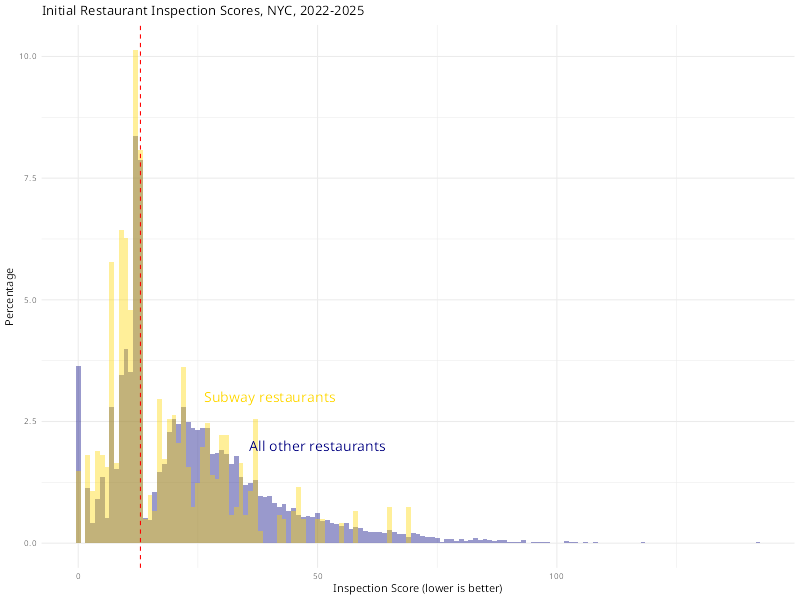

In [10]:
# annotate() can add text or shapes to a graph. We specify the location of 
# the text with the x and y axis arguments. 

plot3 <- plot2 + 
  geom_vline(aes(xintercept = 13), color = "red", linetype = "dashed") +
  annotate("text", x = 40, y = 3, label = "Subway restaurants", size = 5, color = "gold") +
  annotate("text", x = 50, y = 2, label = "All other restaurants", size = 5, color = "navy")

plot3

We can also repeat a graph over another variable. This is called *faceting* or creating *small multiples*. In `ggplot()` add a `facet_grid` or `facet_wrap` layer to your plot: 

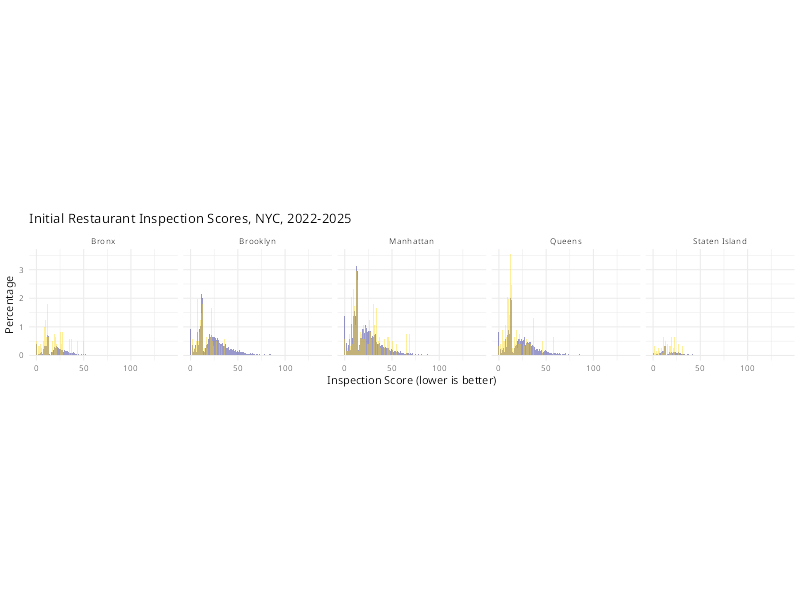

In [11]:
# I switched back to plot2 because the text 
# added in annotate() is outside the range of this graph

plot2 + facet_grid(~ BORO) + theme(aspect.ratio = .75)

### Boxplots and Violin plots

Boxplots show a bunch of information: the median, the inter-quartile range (IQR), and outliers are all presented simply. Boxplots are also handy plots for graphing distributions by a grouping variable. Let's take a inspection scores by NYC boro using `geom_boxplot()`.

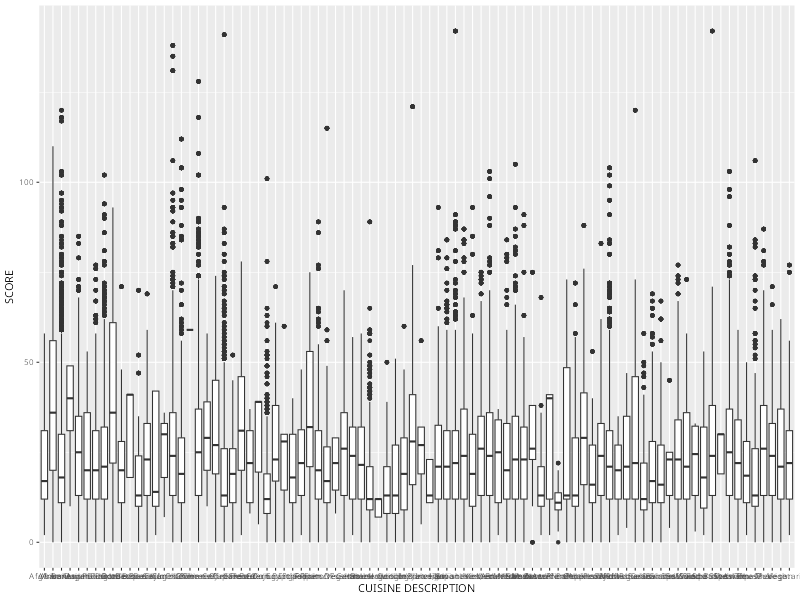

In [12]:
# in order to access variable name with a space in it, enclose in
# `` tick marks. Do not use single quotes! ''. 

ggplot(nyc.inspect, mapping = aes(y = SCORE, x = `CUISINE DESCRIPTION`)) + 
  geom_boxplot()


Yikes. That doesn't look so good. We have way too many categories. Let's select just some of the biggest categories using `filter()` and flip the x and y axes.

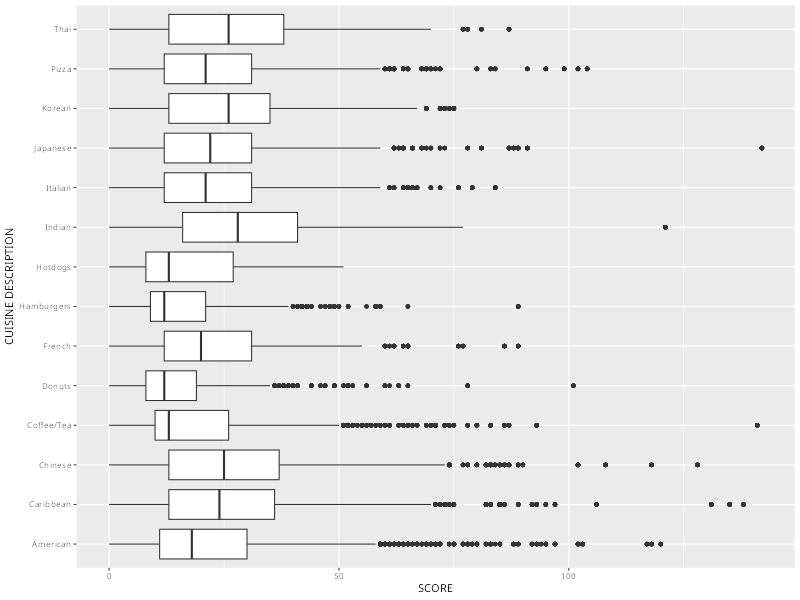

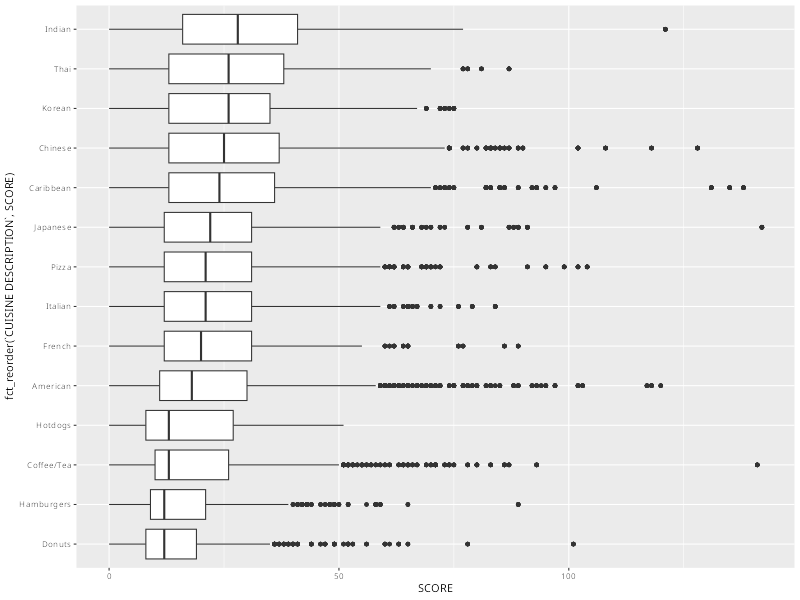

In [13]:
# first, create a list of cuisines. These are values in `CUISINE DESCRIPTION`
cuisines <- c("American", "Chinese", "Pizza", "Italian", "French", "Korean", 
                "Coffee/Tea", "Mexian", "Thai", "Japanese", "Indian",
                "Hamburgers", "Hotdogs", "Caribbean", "Donuts")

# now filter just those observations where `CUISINE DESCRIPTION`
# is included in the list we created above. 
# the filter call basically says: `CUISINE DESCRIPTION` is found in list "cuisines"
ggplot(nyc.inspect |> filter(`CUISINE DESCRIPTION` %in% cuisines), 
    mapping = aes(x = SCORE, y = `CUISINE DESCRIPTION`)) + 
    geom_boxplot()

# This looks a lot better if we order the groups by SCORE. We can do that using
# the fct_reorder() function below.
ggplot(nyc.inspect |> filter(`CUISINE DESCRIPTION` %in% cuisines), 
    mapping = aes(x = SCORE, y = fct_reorder(`CUISINE DESCRIPTION`, SCORE))) + 
    geom_boxplot()    

Violin plots present similar information as a density plot. 

Warning message:
The `draw_quantiles` argument of `geom_violin()` is deprecated as of ggplot2
4.0.0.
ℹ Please use the `quantiles.linetype` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


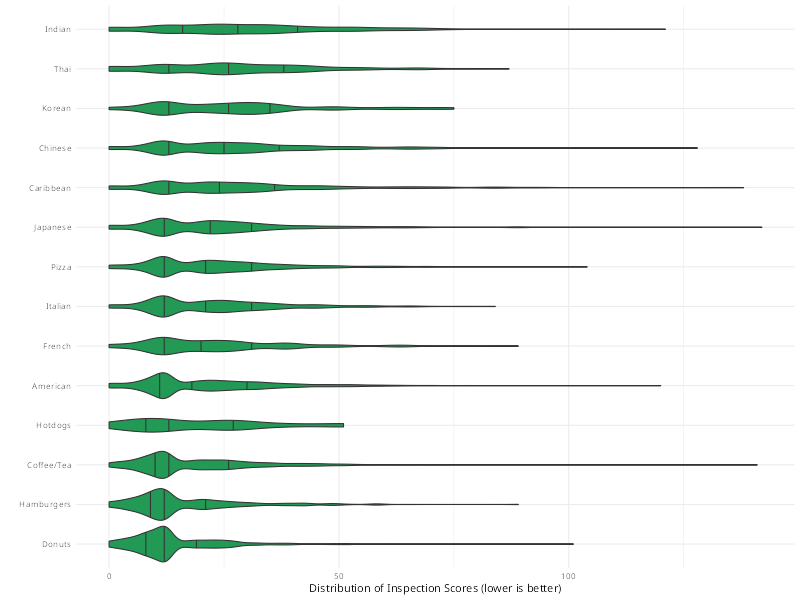

In [14]:
# includes lines at p25, median and p75
ggplot(nyc.inspect |> filter(`CUISINE DESCRIPTION` %in% cuisines), 
    mapping = aes(x = SCORE, y = fct_reorder(`CUISINE DESCRIPTION`, SCORE))) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), fill = "#229954") +
    labs(y = "",
         x = "Distribution of Inspection Scores (lower is better)") +
    theme_minimal()

### Loess and Line Graphs

Loess plots use locally-weighted regression models to estimated moving averages of your outcome variable over values of some predictor or x variable. There really nice ways of presenting trends of an outcome when you have many cases. 

Here, let's use `ggplot`'s `geom_smooth()` function to examine the average inspection score over time. Given that loess is computationally demanding, let's just use restaurants in Queens. 


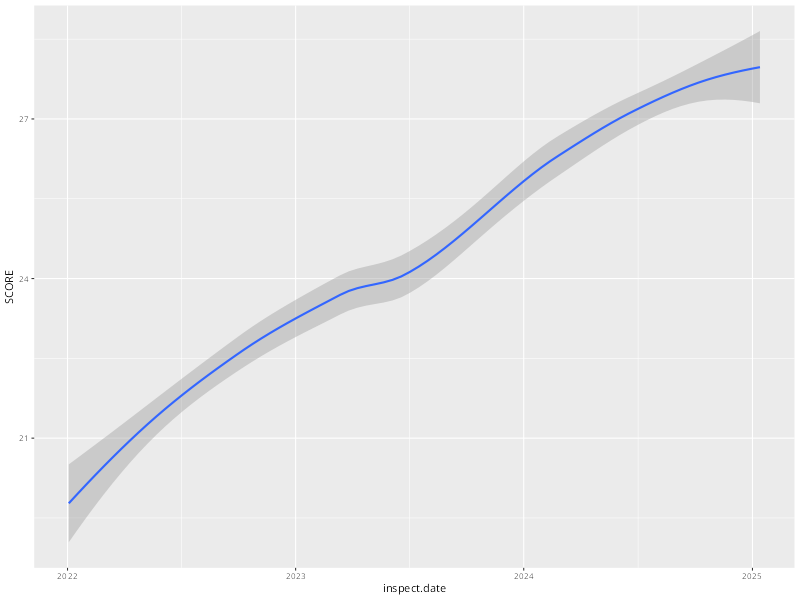

`geom_smooth()` using formula = 'y ~ x'

In [15]:
ggplot(nyc.inspect |> filter(BORO == "Queens"), aes(x = inspect.date, y = SCORE)) +
    geom_smooth(method = "loess")

Hmm. That is an interesting trend. I wonder if it is the same across all the NYC boroughs? Instead of using loess for this, let's summarize our data by quarter and present as line graphs. 

`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.


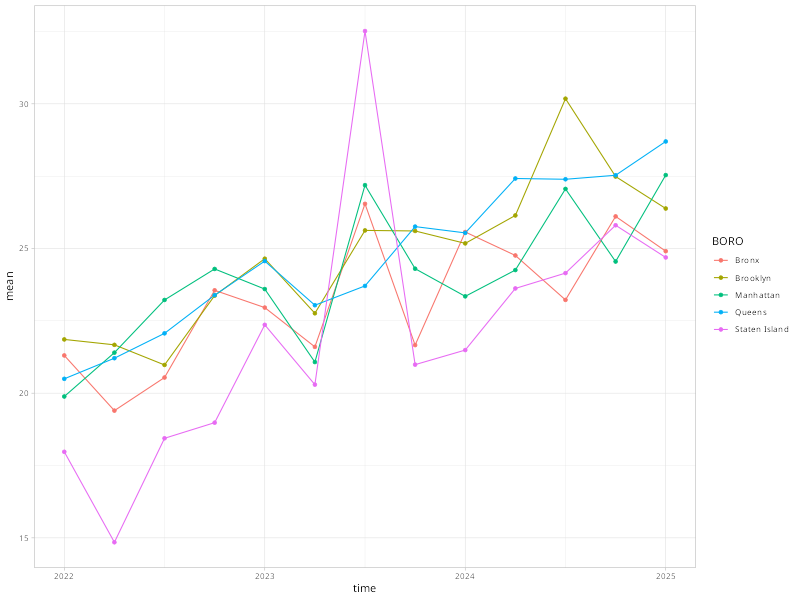

In [16]:
# let's create our quarterly time variable 

nyc.inspect <- nyc.inspect |> mutate(quarters = case_when ( 
                                        inspect.month < 4 ~ 0,
                                        inspect.month >= 4 & inspect.month < 7 ~ .25,
                                        inspect.month >= 7 & inspect.month < 10 ~ .50,
                                        inspect.month >=10 ~ .75,
                                        TRUE ~ NA),
                                    time = inspect.year + quarters)

# now let's group our data by our new time variable and boro and summarize 

small.df <- nyc.inspect |> group_by(time, BORO) |>
                           summarize(mean = mean(SCORE, na.rm = TRUE),
                                     sd = sd(SCORE, na.rm = TRUE))

head(small.df)

# now we can make our line graphs!

ggplot(data = small.df, mapping = aes(x = time, y = mean, group = BORO, color = BORO)) + 
    geom_line() +
    geom_point() +
    theme_light()

### Presenting Mean Comparisons as Bar Graphs

`ggplot` has, in my opinion, a strange way to presented calculated statistics in graph form. The `geom`s we've been using are designed to present data, not calculate statisics. But we can get there. In this example, let's code for all initial inspections that find evidence of mice, and then graph the proportion of inspections finding mice by `BORO`. 

Warning message:
Removed 244 rows containing non-finite outside the scale range
(`stat_summary()`). 


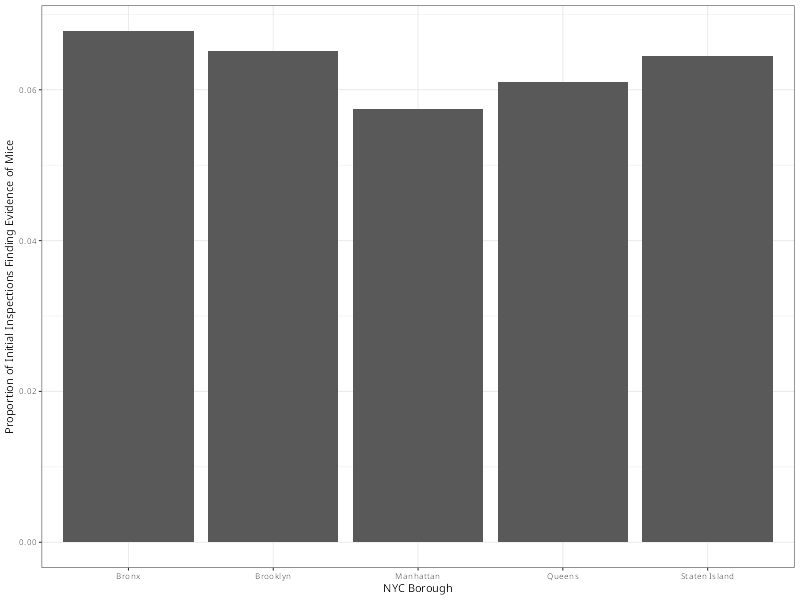

In [17]:
# str_detect() is a useful string function built into stringr,
# part of the tidyverse. It identifies a series of text characters
# inside of a vector of data or a list, and then outputs TRUE if
# finds the characters, the pattern. 

# syntax: str_detect(vector or list name, 'pattern')

# here we wrap str_detect inside of an ifelse statement. Those
# inspections with "mice" get a 1, valid but missing the string 
# get 0. Missing data receive NA.

# Now, why might `VIOLATION DESCRIPTION` be NA? Could be missing data
# but could also be no violations. Let's replace our new mice variable with
# another if_else call, this time code no violations into 0s and leaving 
# everything else the same.

nyc.inspect <- nyc.inspect |>
                mutate(mice = if_else(str_detect(`VIOLATION DESCRIPTION`,'mice'), 
                                1, 0, missing = NA),
                    mice = if_else(str_detect(`VIOLATION CODE`, 'No violations were recorded at the time of this inspection'),
                                0, mice))

#check the data
table(nyc.inspect$mice,useNA = "always")

# Create the graph

ggplot(nyc.inspect, mapping = aes(x = BORO, y = mice)) +
    stat_summary(geom = "col", fun = "mean") +
    labs(x = "NYC Borough", 
         y = "Proportion of Initial Inspections Finding Evidence of Mice") +
    theme_bw()